In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [178]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='Unnamed: 0')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              136 non-null    float64
 1   crude_oil_brent_usd_per_bbl              140 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         140 non-null    float64
 3   inflación_mensual                        140 non-null    float64
 4   ipc_diesel                               140 non-null    float64
 5   precipitación_media_mm                   132 non-null    float64
 6   temp_media_Celsius                       132 non-null    float64
 7   fob_otros_prod_agrícolas_exportados_usd  140 non-null    float64
 8   fosfato diamónico 18-46-0                140 non-null    float64
 9   muriato de potasio 0-0-60                140 non-null    float64
 10  urea 46-0-0                    

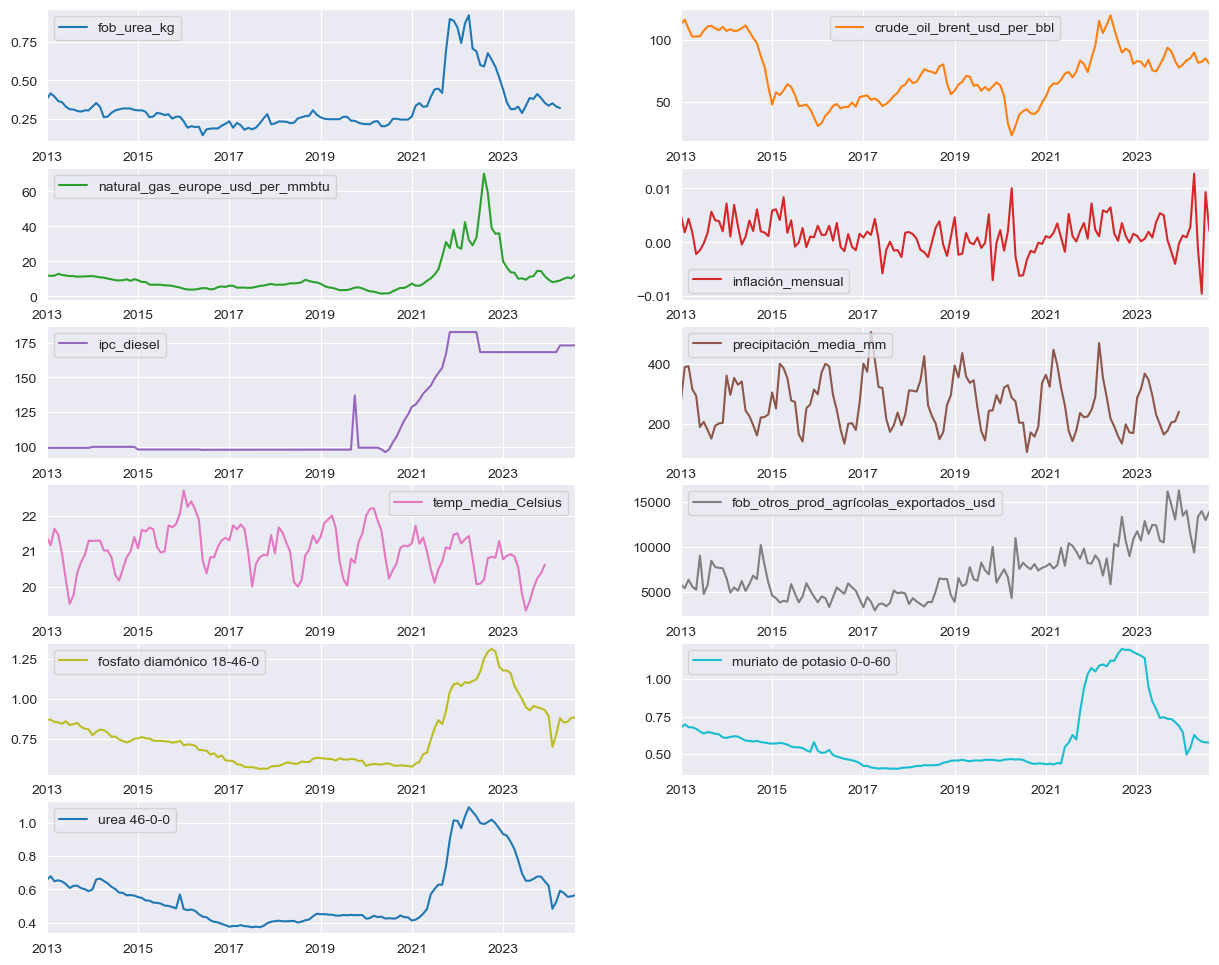

In [179]:
num_de_filas = ((df.shape[1] + 1) // 2)

df.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

### Diferenciación no-estacional y estacional

Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*:

In [180]:
# Eliminar valores nulos para análisis de estacionareidad:
df_sin_na = df.dropna()

In [181]:
# Extraer valores de meses para creación de índices tras diferenciación:
mes_2 = df_sin_na.index.min() + pd.DateOffset(months=1)
mes_2 = mes_2.strftime('%Y-%m')

mes_3 = df_sin_na.index.min() + pd.DateOffset(months=2)
mes_3 = mes_3.strftime('%Y-%m')

mes_4 = df_sin_na.index.min() + pd.DateOffset(months=3)
mes_4 = mes_4.strftime('%Y-%m')

último_mes = df_sin_na.index.max() + pd.DateOffset(months=1)
último_mes = último_mes.strftime('%Y-%m')

In [182]:
# Evaluar estadísticos ADF y KPSS de estacionareidad sobre datos originales:
df_test_estacionareidad = evaluar_estacionareidad(df_sin_na)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.361962e-01,0.022258,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.067201e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.756353e-01,0.031976,False,True,No estacionario
3,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
4,ipc_diesel,9.639810e-01,0.010000,False,True,No estacionario
5,precipitación_media_mm,1.298639e-01,0.100000,False,False,No claro
6,temp_media_Celsius,5.043799e-01,0.100000,False,False,No claro
7,fob_otros_prod_agrícolas_exportados_usd,9.990506e-01,0.010000,False,True,No estacionario
8,fosfato diamónico 18-46-0,3.972852e-01,0.023077,False,True,No estacionario
9,muriato de potasio 0-0-60,4.079042e-01,0.019878,False,True,No estacionario


#### Diferenciación d=1:

In [225]:
q_inferior = 0
q_superior = 1

In [226]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# Extraer nombres de variables que no son originalmente estacionarias:
variables_no_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] != 'Estacionario']['variable'].values

# Crear un df de variables no estacionarias:
df_no_estacionarias = df_sin_na[variables_no_estacionarias]

# Diferenciar para d=1 y agregar sufijo:
df_no_estacionarias_diferenciadas_d1 = df_no_estacionarias\
    .apply(np.diff, n=1)\
    .add_suffix("_d1")

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d1.index = pd.date_range(start=mes_2, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d1_tmd = df_no_estacionarias_diferenciadas_d1\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

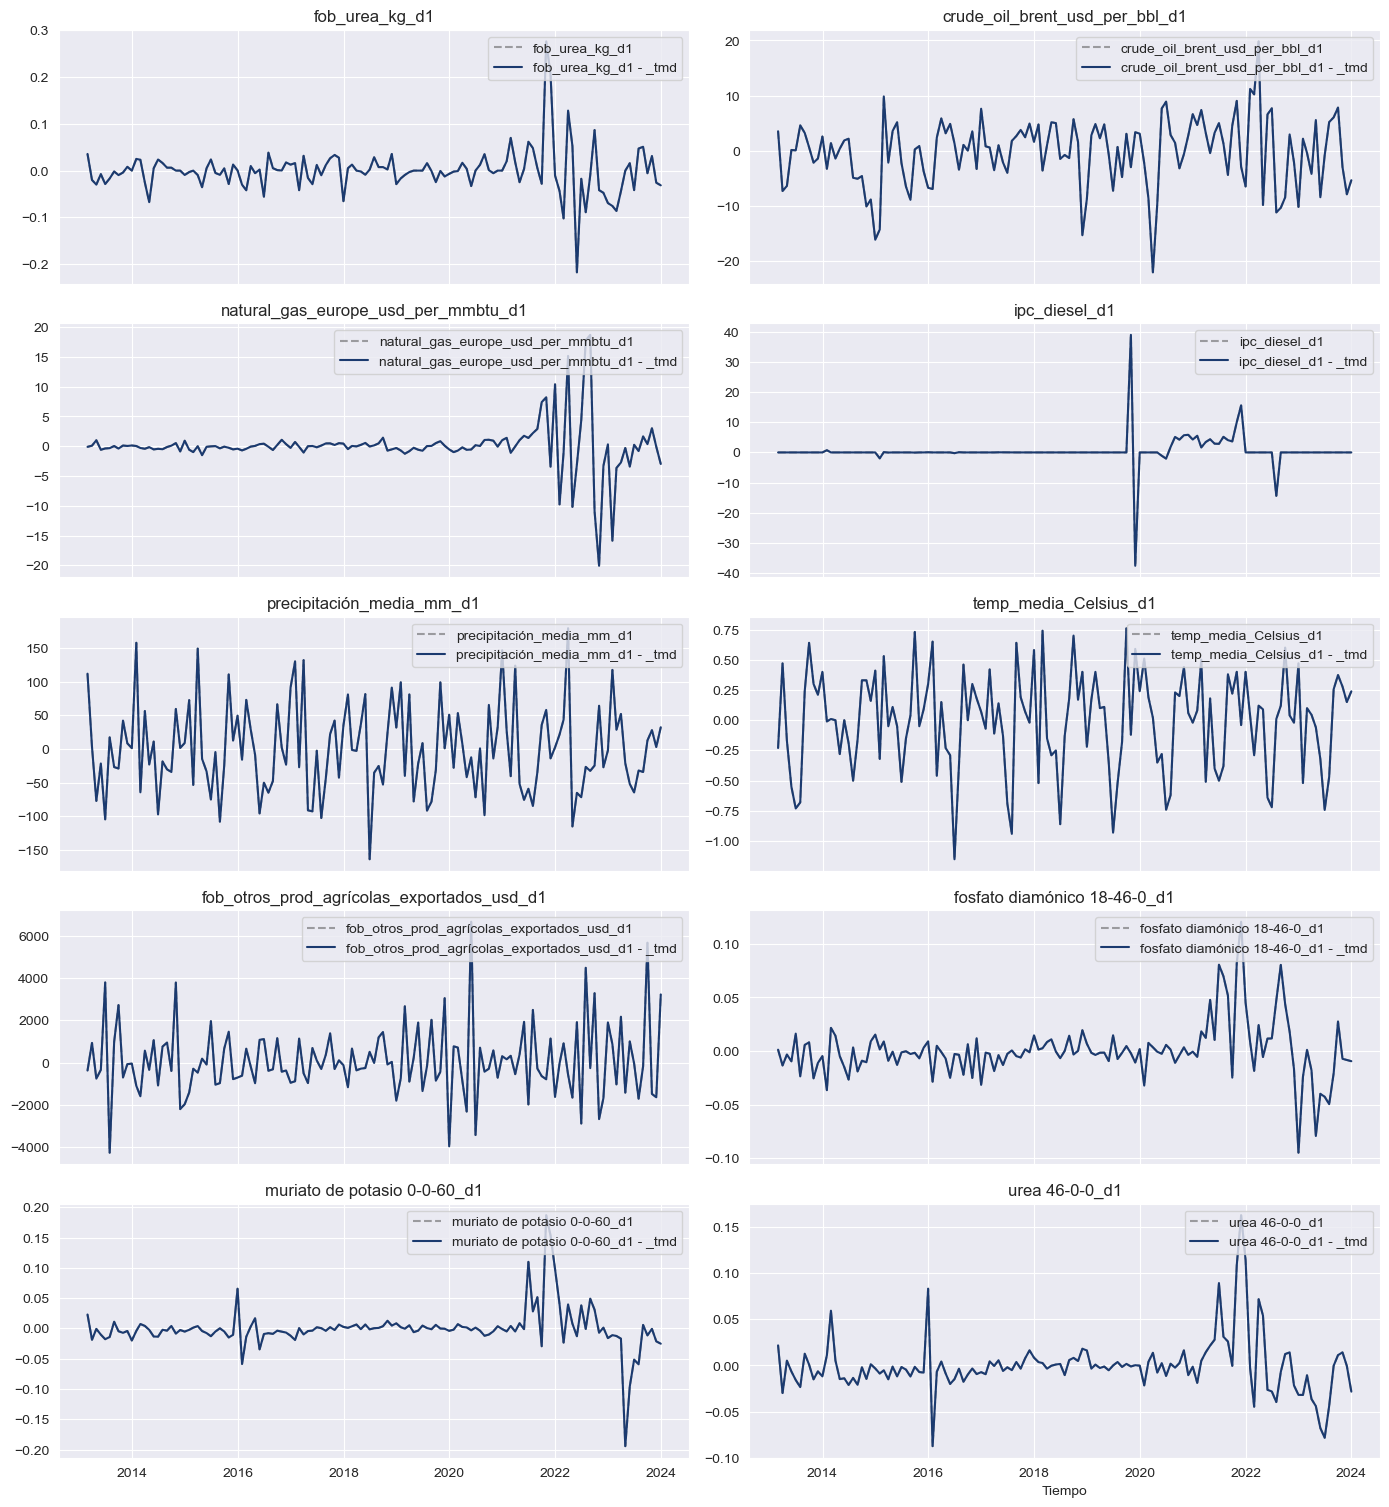

In [227]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d1, df_no_estacionarias_diferenciadas_d1_tmd, suffix='_tmd')

In [228]:
# Evaluar estadísticos ADF y KPSS de estacionareidad tras diferenciación d=1 y recorte:
df_test_estacionareidad_d1 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d1_tmd)

df_test_estacionareidad_d1

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg_d1,5.766319e-04,0.100000,True,False,Estacionario
1,crude_oil_brent_usd_per_bbl_d1,2.910688e-13,0.100000,True,False,Estacionario
2,natural_gas_europe_usd_per_mmbtu_d1,1.462501e-05,0.100000,True,False,Estacionario
3,ipc_diesel_d1,5.673885e-28,0.100000,True,False,Estacionario
4,precipitación_media_mm_d1,1.886255e-13,0.100000,True,False,Estacionario
5,temp_media_Celsius_d1,4.286040e-02,0.100000,True,False,Estacionario
6,fob_otros_prod_agrícolas_exportados_usd_d1,2.730360e-01,0.041667,False,True,No estacionario
7,fosfato diamónico 18-46-0_d1,1.256858e-02,0.100000,True,False,Estacionario
8,muriato de potasio 0-0-60_d1,4.067098e-05,0.100000,True,False,Estacionario
9,urea 46-0-0_d1,6.081601e-02,0.100000,False,False,No claro


In [229]:
# Extraer nombres de variables que no son estacionarias después de d=1 pero antes del recorte:
variables_no_estacionarias_tras_d1 = df_test_estacionareidad_d1[df_test_estacionareidad_d1['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d1_tmd = df_no_estacionarias_diferenciadas_d1_tmd\
    .drop(columns=variables_no_estacionarias_tras_d1)\
    .add_suffix('_tmd')

df_variables_estacionarias_d1_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2013-02-28 to 2023-12-31
Freq: ME
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg_d1_tmd                       131 non-null    float64
 1   crude_oil_brent_usd_per_bbl_d1_tmd       131 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu_d1_tmd  131 non-null    float64
 3   ipc_diesel_d1_tmd                        131 non-null    float64
 4   precipitación_media_mm_d1_tmd            131 non-null    float64
 5   temp_media_Celsius_d1_tmd                131 non-null    float64
 6   fosfato diamónico 18-46-0_d1_tmd         131 non-null    float64
 7   muriato de potasio 0-0-60_d1_tmd         131 non-null    float64
dtypes: float64(8)
memory usage: 9.2 KB


#### Diferenciación d=2:

In [230]:
# Crear un df de variables no estacionarias tras d=1 pero antes del recorte de extremos:
df_no_estacionarias_d1 = df_no_estacionarias_diferenciadas_d1[variables_no_estacionarias_tras_d1]

# Segunda diferenciación de variables no estacionarias tras d=1:
df_no_estacionarias_diferenciadas_d2 = df_no_estacionarias_d1.apply(np.diff, n=1)

# Cambiar el nombre de columnas para identificar 'd=2':
df_no_estacionarias_diferenciadas_d2.columns = [col.replace("_d1", "_d2") for col in df_no_estacionarias_diferenciadas_d2.columns]

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d2.index = pd.date_range(start=mes_3, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d2_tmd = df_no_estacionarias_diferenciadas_d2\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

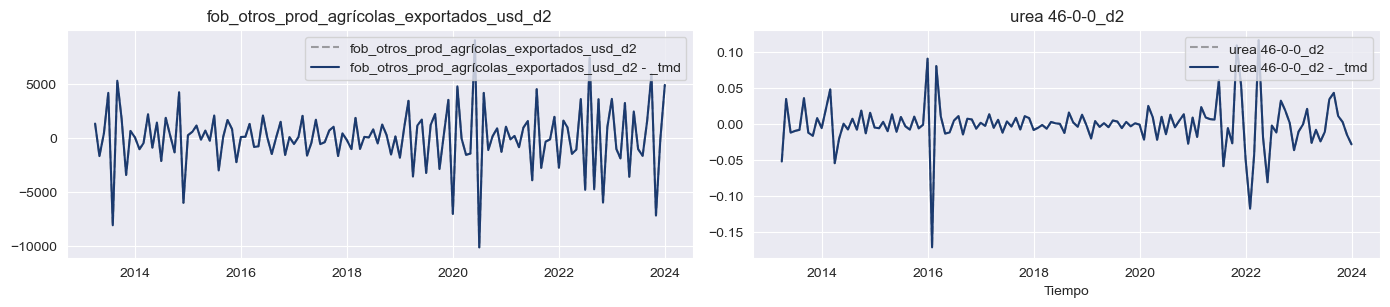

In [231]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d2, df_no_estacionarias_diferenciadas_d2_tmd, suffix='_tmd')

In [232]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad_d2 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d2_tmd)

df_test_estacionareidad_d2

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_otros_prod_agrícolas_exportados_usd_d2,1.788729e-14,0.1,True,False,Estacionario
1,urea 46-0-0_d2,3.545991e-18,0.1,True,False,Estacionario


In [233]:
# Extraer nombres de variables que no son estacionarias después de d=2 pero antes del recorte:
variables_no_estacionarias_tras_d2 = df_test_estacionareidad_d2[df_test_estacionareidad_d2['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d2_tmd = df_no_estacionarias_diferenciadas_d2_tmd\
    .drop(columns=variables_no_estacionarias_tras_d2)\
    .add_suffix('_tmd')

df_variables_estacionarias_d2_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2013-03-31 to 2023-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   fob_otros_prod_agrícolas_exportados_usd_d2_tmd  130 non-null    float64
 1   urea 46-0-0_d2_tmd                              130 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


#### Diferenciación d=3:

In [234]:
# Crear un df de variables no estacionarias tras d=2 pero antes del recorte de extremos:
df_no_estacionarias_d2 = df_no_estacionarias_diferenciadas_d2[variables_no_estacionarias_tras_d2]

# Tercera diferenciación de variables no estacionarias tras d=2:
df_no_estacionarias_diferenciadas_d3 = df_no_estacionarias_d2.apply(np.diff, n=1)

# Cambiar el nombre de columnas para identificar 'd=3':
df_no_estacionarias_diferenciadas_d3.columns = [col.replace("_d2", "_d3") for col in df_no_estacionarias_diferenciadas_d3.columns]

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d3.index = pd.date_range(start=mes_4, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d3_tmd = df_no_estacionarias_diferenciadas_d3\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))


AttributeError: 'Series' object has no attribute 'columns'

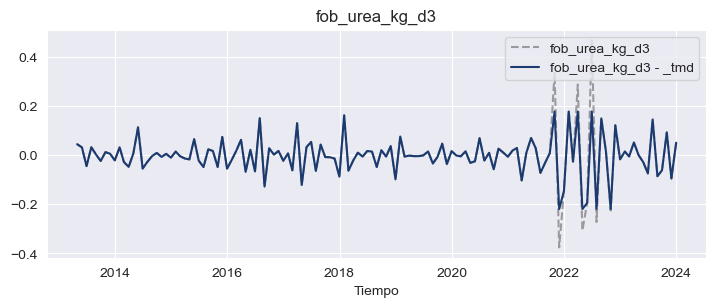

In [213]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d3, df_no_estacionarias_diferenciadas_d3_tmd, suffix='_tmd')

In [214]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad_d3 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d3_tmd)

df_test_estacionareidad_d3

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg_d3,0.008382,0.1,True,False,Estacionario


In [215]:
# Extraer nombres de variables que no son estacionarias después de d=3 pero antes del recorte:
variables_no_estacionarias_tras_d3 = df_test_estacionareidad_d3[df_test_estacionareidad_d3['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=3 y eliminación de atípicos: 
df_variables_estacionarias_d3_tmd = df_no_estacionarias_diferenciadas_d3_tmd\
    .drop(columns=variables_no_estacionarias_tras_d3)\
    .add_suffix('_tmd')

df_variables_estacionarias_d3_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129 entries, 2013-04-30 to 2023-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fob_urea_kg_d3_tmd  129 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


### Cohesión de variables estacionarias y con valores extremos recortados:

In [237]:
# Extraer las variables originalmente estacionarias:
variables_originalmente_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] == 'Estacionario']['variable'].values

df_originalmente_estacionarias = df_sin_na[variables_originalmente_estacionarias]

df_estacionarios = pd.concat(
    [df_originalmente_estacionarias, df_variables_estacionarias_d1_tmd, df_variables_estacionarias_d2_tmd], # df_variables_estacionarias_d3_tmd], 
    axis=1, 
    join='outer'
    )

df_estacionarios = df_estacionarios.fillna(df_estacionarios.mean())

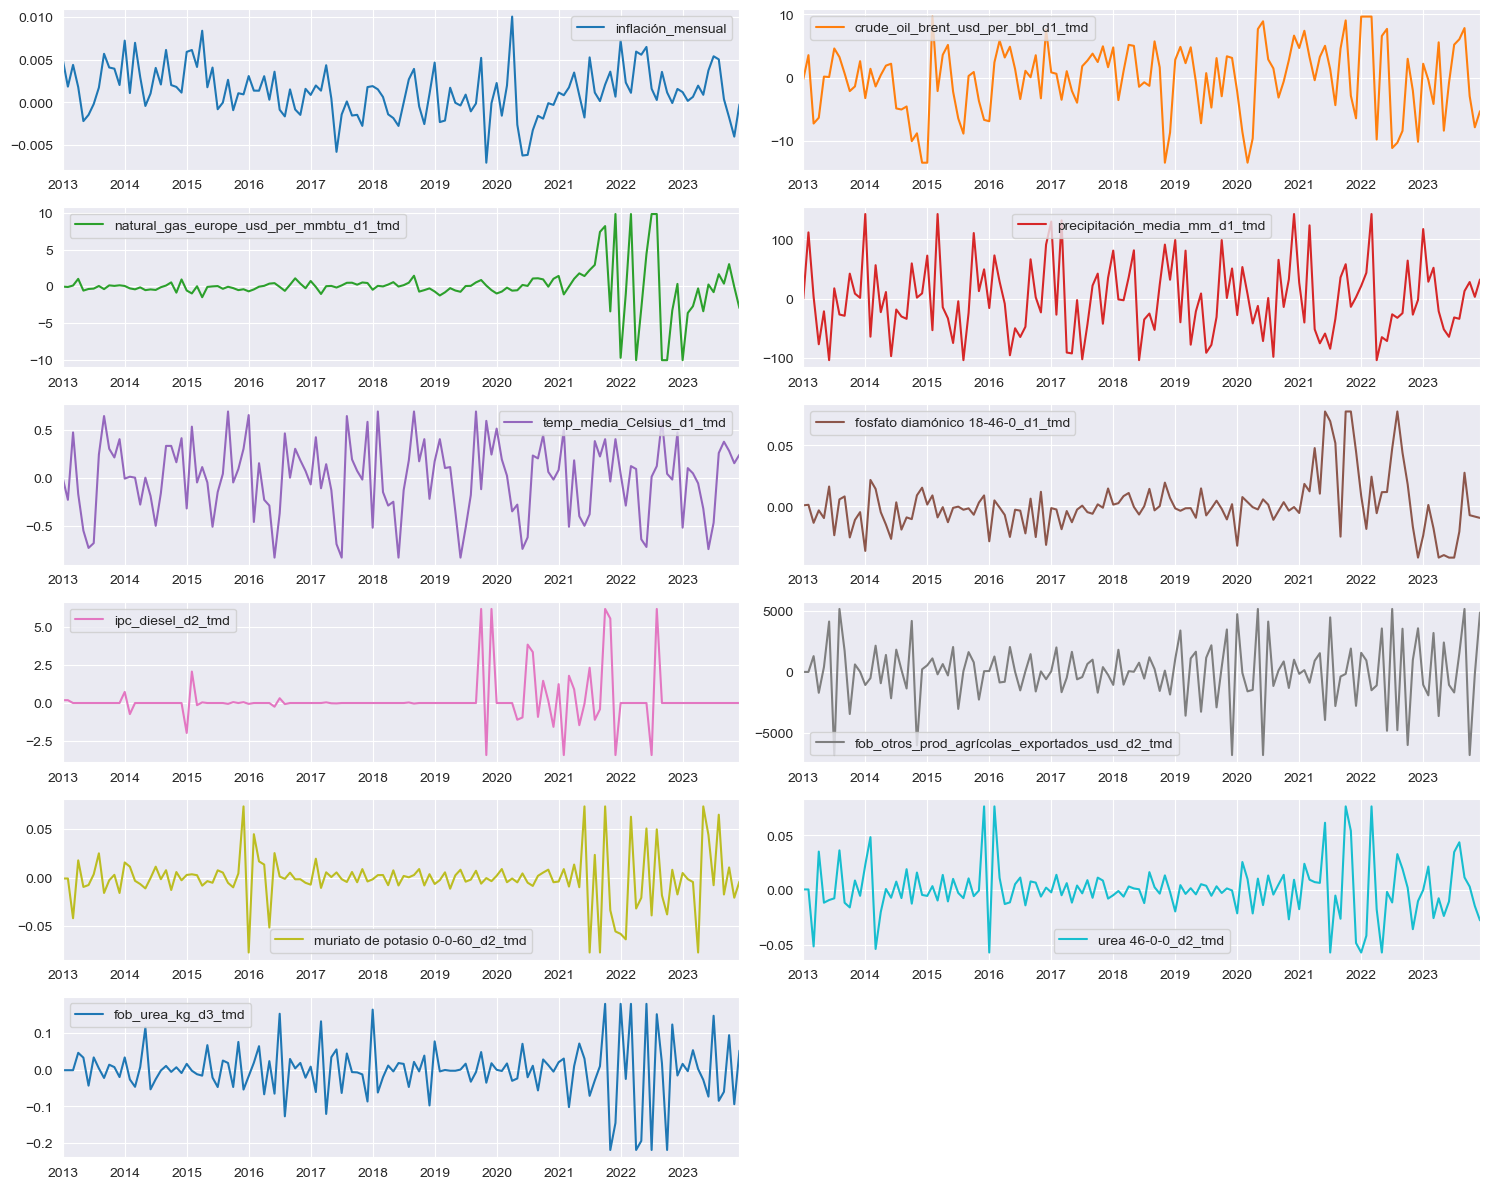

In [217]:
df_estacionarios.plot(
    subplots=True,
    layout=(num_de_filas, 2),
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )

plt.tight_layout()
plt.show()

In [238]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
verificar_estacionareidad = evaluar_estacionareidad(df_estacionarios)

verificar_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
1,fob_urea_kg_d1_tmd,5.778408e-04,0.100000,True,False,Estacionario
2,crude_oil_brent_usd_per_bbl_d1_tmd,2.601508e-13,0.100000,True,False,Estacionario
3,natural_gas_europe_usd_per_mmbtu_d1_tmd,1.324066e-05,0.100000,True,False,Estacionario
4,ipc_diesel_d1_tmd,4.751819e-28,0.100000,True,False,Estacionario
5,precipitación_media_mm_d1_tmd,2.373789e-13,0.100000,True,False,Estacionario
6,temp_media_Celsius_d1_tmd,4.097654e-02,0.100000,True,False,Estacionario
7,fosfato diamónico 18-46-0_d1_tmd,1.233321e-02,0.100000,True,False,Estacionario
8,muriato de potasio 0-0-60_d1_tmd,3.465254e-05,0.100000,True,False,Estacionario
9,fob_otros_prod_agrícolas_exportados_usd_d2_tmd,2.232661e-14,0.100000,True,False,Estacionario


In [240]:
# Extraer variables predictoras:
X = df_estacionarios.drop(columns=['fosfato diamónico 18-46-0_d1_tmd', 'muriato de potasio 0-0-60_d1_tmd', 'urea 46-0-0_d2_tmd'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0_d2_tmd'

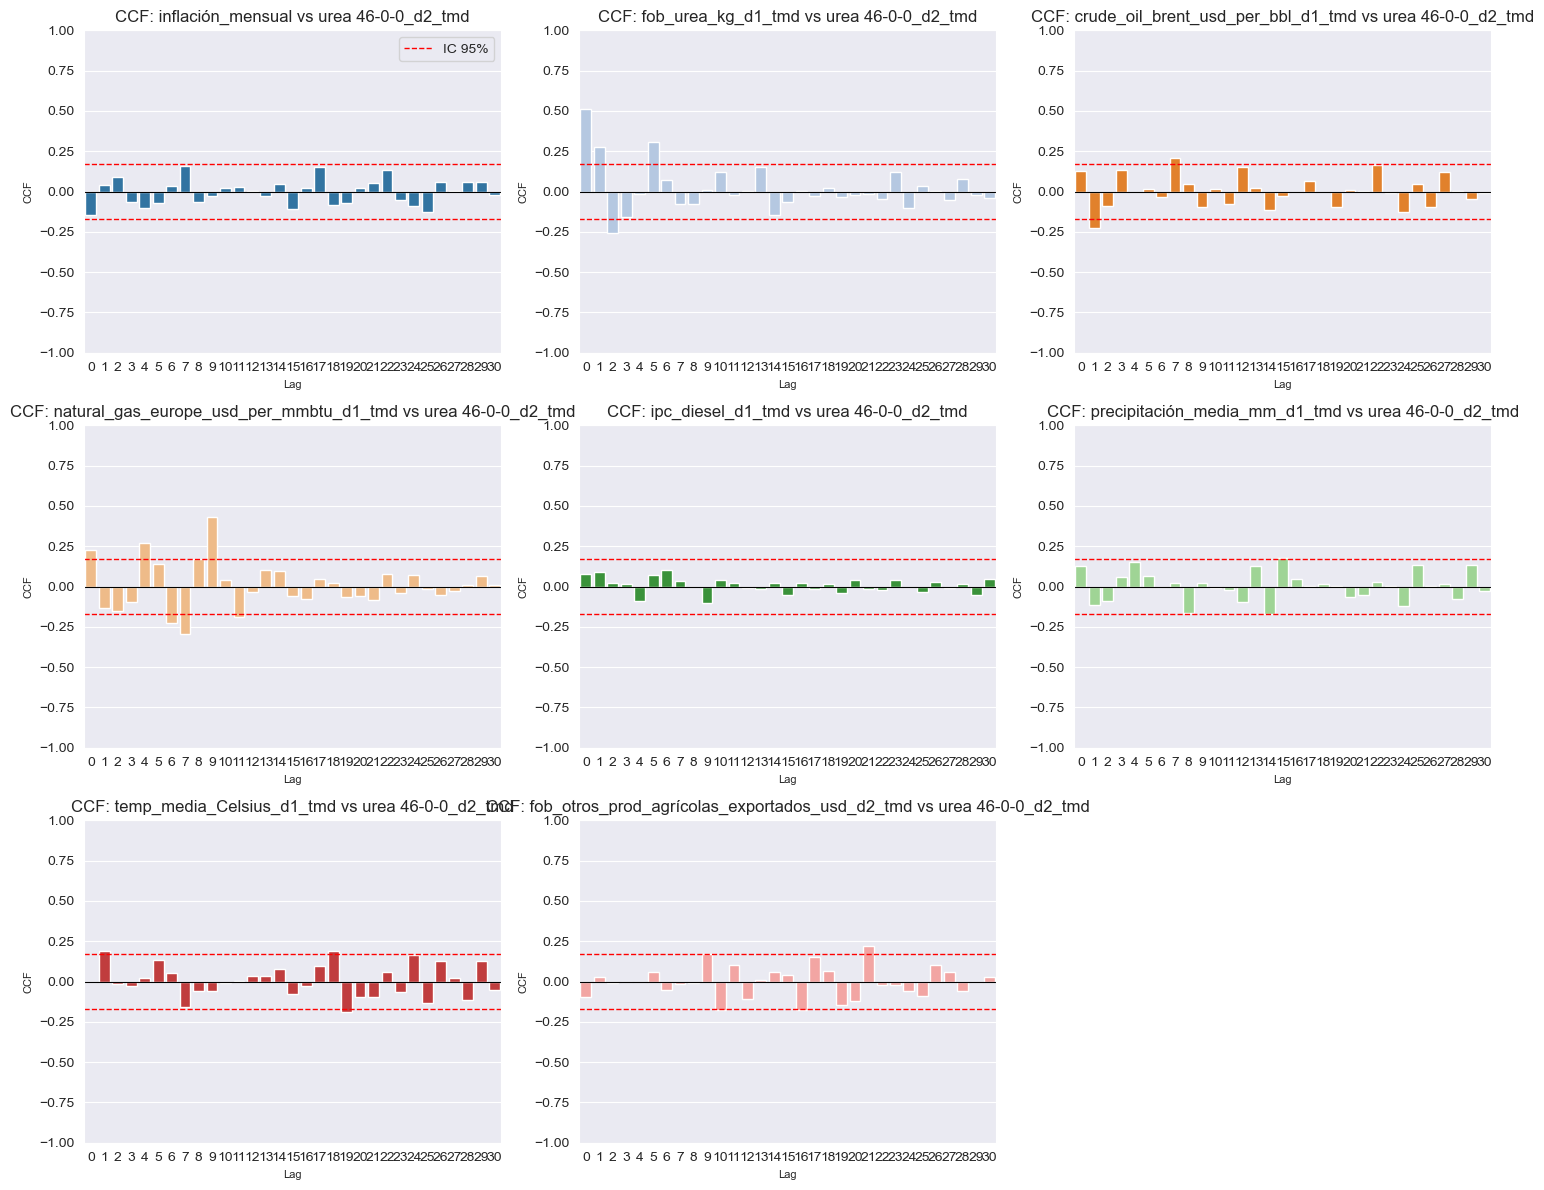

In [241]:
plot_ccf_subplots(df_estacionarios, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")

In [245]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame para almacenar los VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
4,ipc_diesel_d1_tmd,1.185808
1,fob_urea_kg_d1_tmd,1.158986
6,temp_media_Celsius_d1_tmd,1.104933
0,inflación_mensual,1.101082
7,fob_otros_prod_agrícolas_exportados_usd_d2_tmd,1.056916
5,precipitación_media_mm_d1_tmd,1.053060
3,natural_gas_europe_usd_per_mmbtu_d1_tmd,1.038754
2,crude_oil_brent_usd_per_bbl_d1_tmd,1.027230
